In [1]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.optimize import minimize


# Create populations

In [2]:
#population parameters
population_size = 1000
mu_blue = 50
mu_orange = 60

#create populations
blues1 = np.random.normal(mu_blue, 5, (int(population_size/5)*3,1))
blues2 = np.random.normal(mu_blue+20, 5, (int(population_size/5)*2,1))
blues = np.concatenate((blues1, blues2), axis=0)
oranges1 = np.random.normal(mu_orange, 5, (int(population_size/5)*2,1))
oranges2 = np.random.normal(mu_orange+20, 5, (int(population_size/5)*3,1))
oranges = np.concatenate((oranges1, oranges2), axis=0)

#determine who defaulted
blues_who_defaulted = blues < np.random.uniform(0, 100, (population_size,1))
oranges_who_defaulted = oranges < np.random.uniform(0, 100, (population_size,1))

# Plot populations

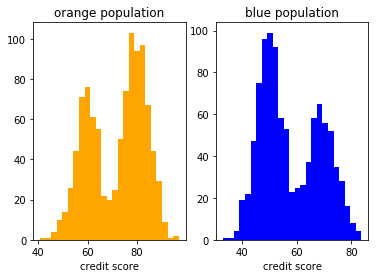

In [3]:
plt.subplot(121)
plt.hist(oranges, bins=25, color="orange")
plt.xlabel("credit score")
plt.title("orange population")
plt.subplot(122)
plt.hist(blues, bins=25, color="b")
plt.xlabel("credit score")
plt.title("blue population")
plt.show()

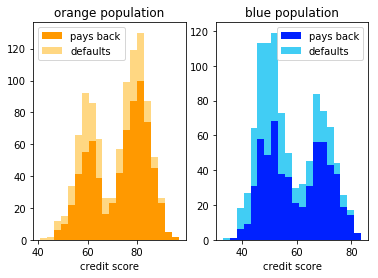

In [4]:
plt.subplot(121)
plt.hist([oranges[np.logical_not(oranges_who_defaulted)],oranges[oranges_who_defaulted]], 
         stacked=True, bins=20, color=("#ff9900", "#ffd782"))
plt.legend(("pays back", "defaults"))
plt.title("orange population")
plt.xlabel("credit score")
plt.subplot(122)
plt.hist([blues[np.logical_not(blues_who_defaulted)],blues[blues_who_defaulted]], 
         stacked=True, bins=20, color=("#0021ff", "#41cdf4"))
plt.legend(("pays back", "defaults"))
plt.title("blue population")
plt.xlabel("credit score")
plt.show()

# Define functions
The functions:  
1. Find the true positive rates of a population.
2. Find the difference between the true positive rates of 2 populations, in order to enforce this condition during optimisation.
3. Find the difference between the selection rates of 2 populations, in order to enforce this condition during optimisation.
4. Find the profit of the bank and ensuing credit rate change of its customers given a population, a cutoff, and the population that actually defaulted.
5. Find the total bank profit given 2 seperate groups (although this should maybe be extended to multiple groups).

In [31]:
#create function that finds true positive rates as a function of the cutoff
def true_positive_rate(population, population_that_defaulted, cutoff):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    number_true_positives = sum(true_positives)
    
    false_negatives = np.logical_and(np.logical_not(population_that_defaulted), 
                                     population_bank_thinks_defaulted)
    
    number_false_negatives = sum(false_negatives) 
    
    true_positive_rate = number_true_positives/(number_true_positives+number_false_negatives)
    
    return true_positive_rate

def difference_bw_positive_rates(pop1, pop2, pop1_that_defaulted, 
                                 pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    true_positive_rate_group1 = true_positive_rate(pop1, pop1_that_defaulted, cutoff1)
    true_positive_rate_group2 = true_positive_rate(pop2, pop2_that_defaulted, cutoff2)
    # for the optimiser's constraints
    return strictness - np.abs(true_positive_rate_group1-true_positive_rate_group2)

def difference_bw_selection_rates(pop1, pop2, pop1_that_defaulted, 
                                  pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    
    _, selection_rate_group1, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    _, selection_rate_group2, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return strictness - np.abs(selection_rate_group1-selection_rate_group2)

#create function that finds bank profit as a function of the cutoff
def bank_profit(population, population_that_defaulted, cutoff, 
                revenue_factor=1, cost_factor=2, credit_upside=1, credit_downside=2):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    paid_back = sum(true_positives)
    false_positives = np.logical_and(population_that_defaulted, 
                                     np.logical_not(population_bank_thinks_defaulted))
    defaulted = sum(false_positives)
    
    profit = paid_back*revenue_factor - defaulted*cost_factor
    selection_rate = sum(np.logical_not(population_bank_thinks_defaulted))/len(population)
    
    credit_change = (paid_back*credit_upside - defaulted*credit_downside)

    
    return profit, selection_rate, credit_change

def total_bank_profit(pop1, pop2, pop1_that_defaulted, pop2_that_defaulted, cutoff1, cutoff2, 
                      revenue_factor=1, cost_factor=3, credit_upside=1, credit_downside=2):
    
    profit_group1, _, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    profit_group2, _, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return -(profit_group1 + profit_group2)

# Optimisations

In this section, we try to find values for cutoffs (values of credit scores below which the bank will not lend and above which the bank will always lend) in two seperate settings.  
In the first setting, we try and maximise bank profit with fairness constraints, specifically the equal opportunity one defined by Liu et. al., which requires equal or almost equal true positive rates between groups.  
In the second setting, we maximise bank profit irrespective of equal opportunity. 

In [32]:
#what to optimise
to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                          oranges_who_defaulted, x[0], x[1])

to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                      oranges_who_defaulted, x[0], x[1])

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50
#show initial objective
print("initial guess of", cutoffs, "got us a profit of ", -to_optimise(cutoffs), "$")

initial guess of [50. 50.] got us a profit of  [-16] $


## 1. With fairness constraints:

In [33]:
#optimise with fairness
a = (0, 100)
bounds = (a, a)
equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
cons = ([equal_true_positives])

solution = minimize(to_optimise, cutoffs, method='SLSQP', constraints = cons,
                    bounds=bounds, options = {'eps': 3})

x_fair = solution.x

In [43]:
#final solution got us a profit of:
print("final guess of", x_fair, "got us a profit of ", -to_optimise(x_fair)[0], "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_fair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_fair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change[0], 
      "|| total credit score change for oranges:", oranges_credit_change[0])

final guess of [52.89843394 51.78529885] got us a profit of  3 $
total credit score change for blues: -174 || total credit score change for oranges: 177


## 2. Without fairness constraints:

In [35]:
#optimise without fairness
a = (0, 100)
bounds = (a, a)

solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP',
                    bounds=bounds, options = {'eps': 3})

x_unfair = solution_unfair.x

In [41]:
#final solution got us a profit of:
print("final guess of", x_unfair, "got us a profit of ", -to_optimise(x_unfair)[0], "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_unfair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_unfair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change[0], 
      "|| total credit score change for oranges:", oranges_credit_change[0])

final guess of [100.          49.19119926] got us a profit of  175 $
total credit score change for blues: 0 || total credit score change for oranges: 175


So to answer the question in the title: no it's not obvious that enforcing equalised odds is good, at least when considering change in credit scores.  

Now let's see how changing the `strictness` parameters in `difference_bw_positive_rates()` (which regulates how closely the true positive rates between the two groups need to be) affects the variables of interest. 

## 3.a. Varying fairness equal opportunity constraints

In [42]:
num_its = 100

In [12]:
profit_eq_opt = np.zeros(100)
credit_change_blues_eq_opt = np.zeros(100)
credit_change_oranges_eq_opt = np.zeros(100)

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50

#optimise bank profit
to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                      oranges_who_defaulted, x[0], x[1])

#impose bounds
a = (0, 100)
bounds = (a, a)

for i in range(100):
    t = time.time()

    to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                          oranges_who_defaulted, x[0], x[1], strictness=(i/100))
    
    equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
    cons = ([equal_true_positives])

    solution = minimize(to_optimise, cutoffs, method='SLSQP', 
                        constraints = cons, bounds=bounds, options = {'eps': 3})

    x = solution.x
    
    index = int(i)
    
    profit_eq_opt[index] = -to_optimise(x)[0]
    _, _, credit_change_blues_eq_opt[index] = bank_profit(blues, blues_who_defaulted, x[0])
    _, _, credit_change_oranges_eq_opt[index] = bank_profit(oranges, oranges_who_defaulted, x[1])
    
    if (i % 20 == 0):
        print("iteration", i, "(which took", time.time() - t, "seconds).")



iteration 0 (which took 9.91609787940979 seconds).
iteration 20 (which took 0.42153024673461914 seconds).
iteration 40 (which took 0.45078206062316895 seconds).
iteration 60 (which took 0.260577917098999 seconds).
iteration 80 (which took 0.4415700435638428 seconds).


## 3.b. Varying fairness demographic parity constraints

In [13]:
profit_dem_par = np.zeros(100)
credit_change_blues_dem_par = np.zeros(100)
credit_change_oranges_dem_par = np.zeros(100)

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50

#optimise bank profit
to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                      oranges_who_defaulted, x[0], x[1])

#impose bounds
a = (0, 100)
bounds = (a, a)

for i in range(100):
    t = time.time()

    to_constrain = lambda x: difference_bw_selection_rates(blues, oranges, blues_who_defaulted, 
                                                          oranges_who_defaulted, x[0], x[1], strictness=(i/100))
    
    equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
    cons = ([equal_true_positives])

    solution = minimize(to_optimise, cutoffs, method='SLSQP', 
                        constraints = cons, bounds=bounds, options = {'eps': 3})

    x = solution.x
    
    index = int(i)
    
    profit_dem_par[index] = -to_optimise(x)[0]
    _, _, credit_change_blues_dem_par[index] = bank_profit(blues, blues_who_defaulted, x[0])
    _, _, credit_change_oranges_dem_par[index] = bank_profit(oranges, oranges_who_defaulted, x[1])
    
    if (i % 20 == 0):
        print("iteration", i, "(which took", time.time() - t, "seconds).")

iteration 0 (which took 2.7164716720581055 seconds).
iteration 20 (which took 0.66945481300354 seconds).
iteration 40 (which took 0.5512070655822754 seconds).
iteration 60 (which took 0.5148732662200928 seconds).
iteration 80 (which took 0.35427021980285645 seconds).


### Plotting the results

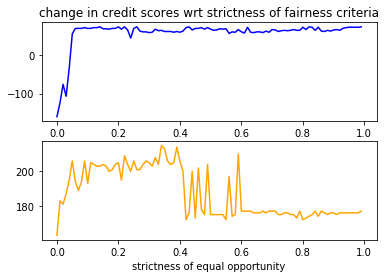

In [22]:
plt.subplot(211)
plt.plot(np.arange(100)/100,credit_change_blues_eq_opt, "blue")
plt.xlabel("strictness of equal opportunity")
plt.title("change in credit scores wrt strictness of fairness criteria")
plt.subplot(212)
plt.plot(np.arange(100)/100,credit_change_oranges_eq_opt, "orange")
plt.xlabel("strictness of equal opportunity")

plt.show()

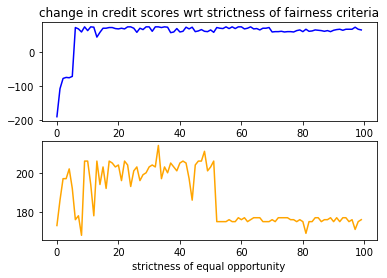

In [15]:
plt.subplot(211)
plt.plot(credit_change_blues_dem_par, "blue")
plt.xlabel("strictness of equal opportunity")
plt.title("change in credit scores wrt strictness of fairness criteria")
plt.subplot(212)
plt.plot(credit_change_oranges_dem_par, "orange")
plt.xlabel("strictness of equal opportunity")

plt.show()

As we can see, relaxing the strictness criteria seems correlated with an increase in the underprivileged population's credit scores. It's worth asking what happens when we change the distribution a little:

## 3.c. Changing the distributions 

In [45]:
profit_change_distributions = np.zeros(100)
credit_change_blues_change_distributions = np.zeros(100)
credit_change_oranges_change_distributions = np.zeros(100)

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50


#impose bounds
a = (0, 100)
bounds = (a, a)

for i in range(100):
    t = time.time()

    #create populations
    mu_blue = 40+i/5
    blues1 = np.random.normal(mu_blue, 5, (int(population_size/5)*3,1))
    blues2 = np.random.normal(mu_blue+i/4, 5, (int(population_size/5)*2,1))
    blues = np.concatenate((blues1, blues2), axis=0)
    blues_who_defaulted = blues < np.random.uniform(0, 100, (population_size,1))
    
    #optimise bank profit
    to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                              oranges_who_defaulted, x[0], x[1])

    to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                          oranges_who_defaulted, x[0], x[1], strictness=(i/100))
    
    equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
    cons = ([equal_true_positives])

    solution = minimize(to_optimise, cutoffs, method='SLSQP', 
                        constraints = cons, bounds=bounds, options = {'eps': 3})

    x = solution.x
    
    index = int(i)
    
    profit_change_distributions[index] = -to_optimise(x)[0]
    _, _, credit_change_blues_change_distributions[index] = bank_profit(blues, blues_who_defaulted, x[0])
    _, _, credit_change_oranges_change_distributions[index] = bank_profit(oranges, oranges_who_defaulted, x[1])
    
    if (i % 20 == 0):
        print("iteration", i, "(which took", time.time() - t, "seconds).")

iteration 0 (which took 0.2012040615081787 seconds).
iteration 20 (which took 5.973872184753418 seconds).
iteration 40 (which took 0.42031407356262207 seconds).
iteration 60 (which took 0.27184104919433594 seconds).
iteration 80 (which took 0.3208119869232178 seconds).


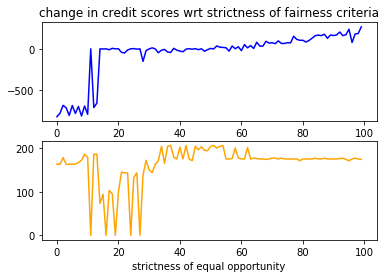

In [47]:
plt.subplot(211)
plt.plot(np.arange(100),credit_change_blues_change_distributions, "blue")
plt.xlabel("strictness of equal opportunity")
plt.title("change in credit scores wrt strictness of fairness criteria")
plt.subplot(212)
plt.plot(np.arange(100),credit_change_oranges_change_distributions, "orange")
plt.xlabel("strictness of equal opportunity")

plt.show()

# Miscellaneous code

### Define true/false positives/negatives

In [18]:
blues_bank_thinks_defaulted = blues < 30
oranges_bank_thinks_defaulted = oranges < 60

#define true and false negatives/positives
true_negative_blues = np.logical_and(blues_who_defaulted, blues_bank_thinks_defaulted)
false_negative_blues = np.logical_and(np.logical_not(blues_who_defaulted), blues_bank_thinks_defaulted)
true_positive_blues = np.logical_and(np.logical_not(blues_who_defaulted), np.logical_not(blues_bank_thinks_defaulted))
false_positive_blues = np.logical_and(blues_who_defaulted, np.logical_not(blues_bank_thinks_defaulted))

### Plot outcome curve

In [19]:
orange_profit = np.zeros(100)
selection_rate_orange = np.zeros(100)
credit_change_orange = np.zeros(100)

blue_profit = np.zeros(100)
selection_rate_blue = np.zeros(100)
credit_change_blue = np.zeros(100)

for i in range(100):
    orange_profit[i], selection_rate_orange[i], credit_change_orange[i] = bank_profit(oranges, oranges_who_defaulted, i)
    blue_profit[i], selection_rate_blue[i], credit_change_blue[i] = bank_profit(blues, blues_who_defaulted, i)

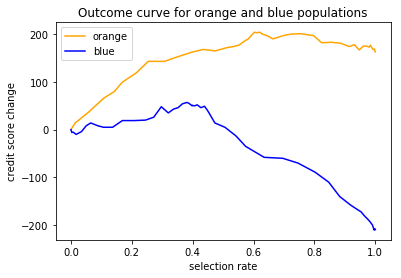

In [48]:
plt.plot(selection_rate_orange, credit_change_orange, 'orange')
plt.plot(selection_rate_blue, credit_change_blue, 'b')
plt.ylabel("credit score change")
plt.xlabel("selection rate")
plt.legend(("orange", "blue"))
plt.title("Outcome curve for orange and blue populations")
plt.show()

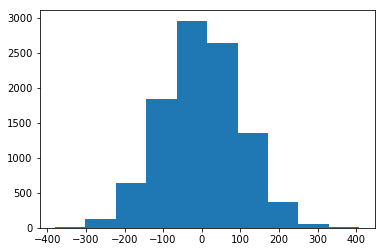

In [50]:
a = np.random.normal(0, 100, (10000,1))
plt.hist(a)
plt.show()